In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Lecture 02

## Implementation of Perceptron

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

## 1. Import Statements

In [2]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
 
%matplotlib inline

## 2. Setup Global Parameters

In [3]:
###----------------
### Some parameters
###----------------

# Directory locations
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 5000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## 3. Generate Data Set
<div style="font-family: Arial; font-size:1.2em;color:black;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [4]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X.shape, y.shape

((1000, 2), (1000,))

## 4. Visualization
<p style="font-family: Arial; font-size:1.2em;color:black;">
DataFrames are easier to visualize
</p>

In [5]:
data_df = pd.DataFrame(X, columns=['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [7]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
A,1000.0,0.490841,0.898951,-1.688795,-0.149565,0.500100,1.095048,2.419113
B,1000.0,0.239025,0.540082,-0.955280,-0.205090,0.241163,0.680394,1.612075
target,1000.0,0.500000,0.500250,0.000000,0.000000,0.500000,1.000000,1.000000


In [8]:
data_df['target'].unique()

array([0, 1])

### 4.1 Different ways of plotting data

<Axes: xlabel='A', ylabel='B'>

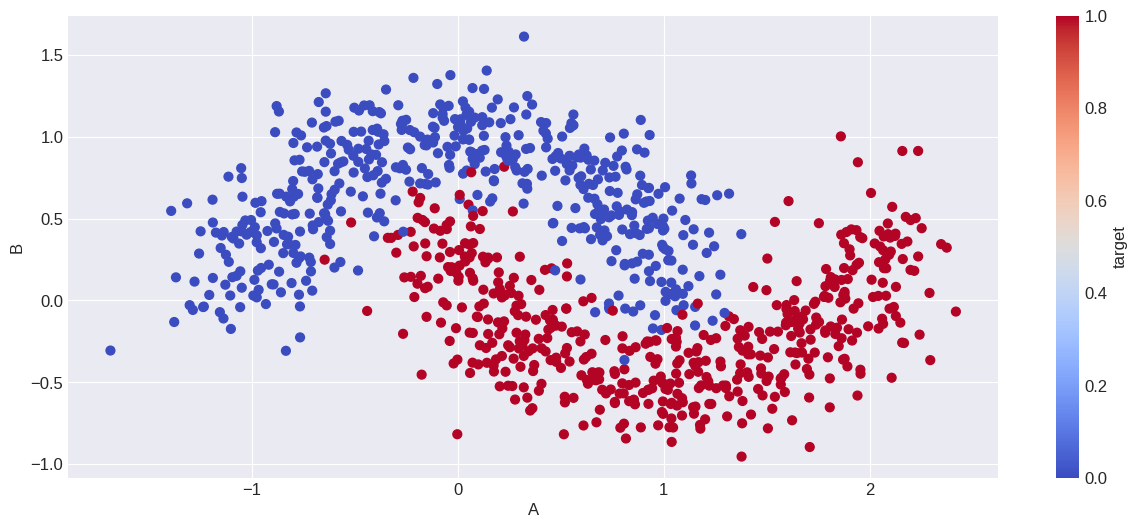

In [9]:
data_df.plot.scatter('A', 'B', s=40, c = 'target', cmap = CMAP)

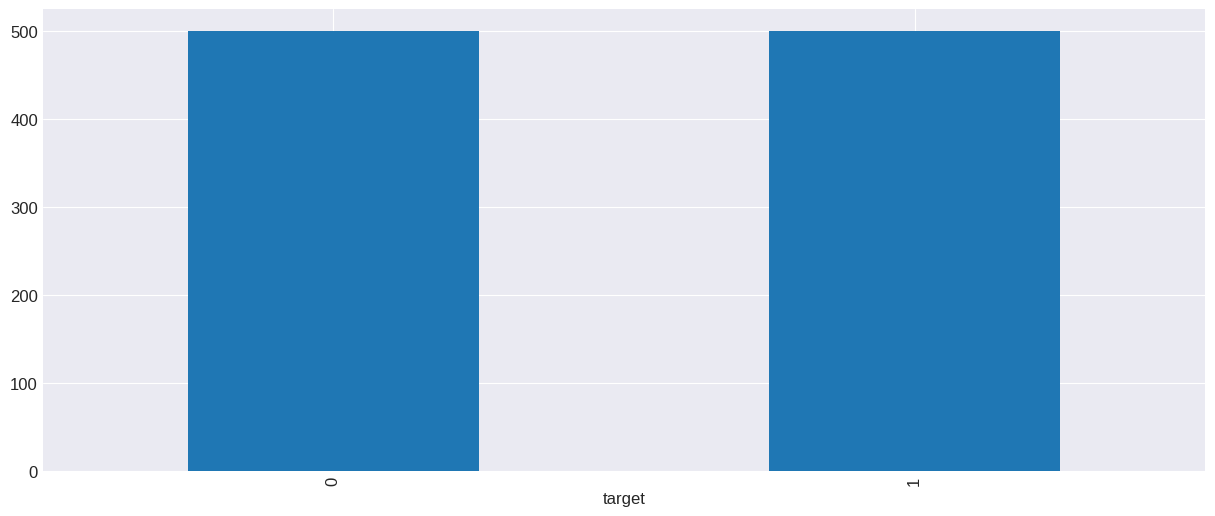

In [10]:
data_df['target'].value_counts().plot(kind = 'bar');

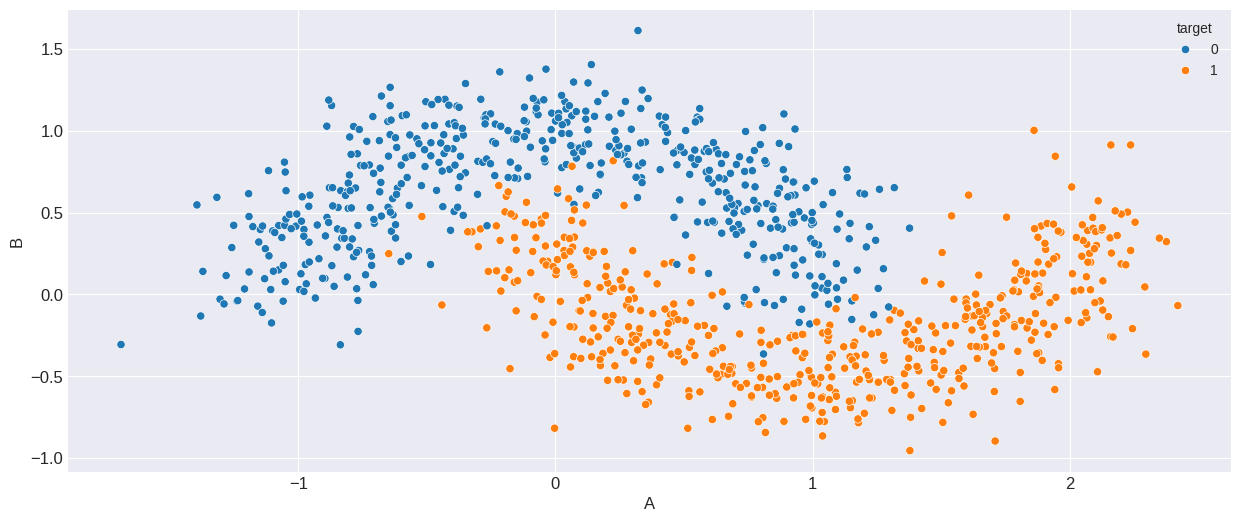

In [11]:
sns.scatterplot(x ='A', y='B', data = data_df, hue = 'target');

<div style="font-family: Arial; font-size:1.2em;">
    We will keep 10%, i.e. 100 records for testing and remaining records will be used in training. Note that the data is already random.
</div>

In [12]:
data_train = data_df.to_numpy()[:900]
data_test = data_df.to_numpy()[900:]
data_train.shape, data_test.shape

((900, 3), (100, 3))

# Over to Perceptron

<div style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in the lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>

<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>


$$
\begin{aligned}
z & = 1.0 \circ w_0 + x_1 \circ w_1 + x_2 \circ w_2 \\
\mathrm{or}\\
z & = X\circ W \\
\end{aligned}
$$
<br/>


$$
\begin{equation*}
    \hat{y} = \begin{cases}
      1.0, & \text{for z>=0}\  \\
      0.0, & \text{for z<0}\
    \end{cases}
\end{equation*}
$$

<div style="font-family: Arial; font-size:1.2em;">
<p>
As we know that adjustments in the weights are (a-$\hat{y}$). We don't want to adjust by full value. It makes convergence easier if we adjust by a small fraction. </p>
    <p><b>Why?</b> We would know better all through this module. We will circle back to learning_rate after some sessions.
<p>Let's assume that adjusting weights by $\alpha$ * ( a - $\hat{y}$ ) makes better sense. </p>
<p>
    <strong>Note:</strong> Take learning_rate ($\alpha$) as some constant.
</p>
</div>

## Sigmoid Function

In [13]:
def fn_sigmoid(z):

    return 1/(1+np.exp(-z))

In [14]:
fn_sigmoid(np.array([-np.inf, 0, 0.5, 1, np.inf]))

array([0.        , 0.5       , 0.62245933, 0.73105858, 1.        ])

## 5. Prediction

In [15]:
# A function to make predictions

def predict(row, wt):

    z = wt[0] # get w0
    
    for i in range(len(row)-1):

        z = wt[i+1] * row[i] + z # update for w1 and w2

    return fn_sigmoid(z) # change for sigmoid function

**Its advisable to test the function**

In [16]:
#Unit test
weights = np.array([0.1, 2.0, 1.0])

display(data_df.loc[0])

predict(data_df.loc[0].values, weights)

A         0.906340
B         0.902676
target    0.000000
Name: 0, dtype: float64

0.9434999754763397

<div style="font-family: Arial; font-size:1.2em;">
    <h3>Back-propagation - Estimate Perceptron weights </h3>
    $
\begin{aligned}
\partial{z}  & = a - y \\
\partial{b}  & = \partial{z} \\
\partial{w_1}  & = x_1 \circ \partial{z}\\
\partial{w_2}  & = x_2 \circ \partial{z}\\
\end{aligned}
$
    <hr>
      $
\begin{aligned}
b & = b -  \frac{1}{m} (\alpha \circ \partial{b}) \\
w_1  & = w_1 - \frac{1}{m}(\alpha \circ \partial{w_1} )\\
w_2  & = w_2 - \frac{1}{m}(\alpha \circ \partial{w_2} )\\
\end{aligned}
$
    </div>
    
 ## 6. Training

In [17]:
# Function to train the model

def train_weights (train, alpha = ALPHA, n_epoch = EPOCHS):

    errors = []   # to collect errors
    
    weights = rng.random(train.shape[1])   # weights at random
    
    m = train.shape[0]  # num examples

    for epoch in range(n_epoch): #

        sum_error = 0
        
        for row in train:
            
            prediction = predict(row, weights)
            
            dz = prediction - row[-1] # (a-y)

            error = - row[-1]* np.log(prediction) # changes due to Sigmoid function
            
            sum_error += error
            
            weights[0] = weights[0] - alpha* dz/m

            for i in range(len(row)-1):

                weights[i+1] =  weights[i+1] - alpha * dz * row[i] /m

        errors.append(sum_error/m)

    return errors, weights

In [18]:
# calling 'train_weight'

errors, weights = train_weights(data_train, ALPHA, EPOCHS)

print(weights)

[ 0.53899411  1.18613247 -4.71566874]


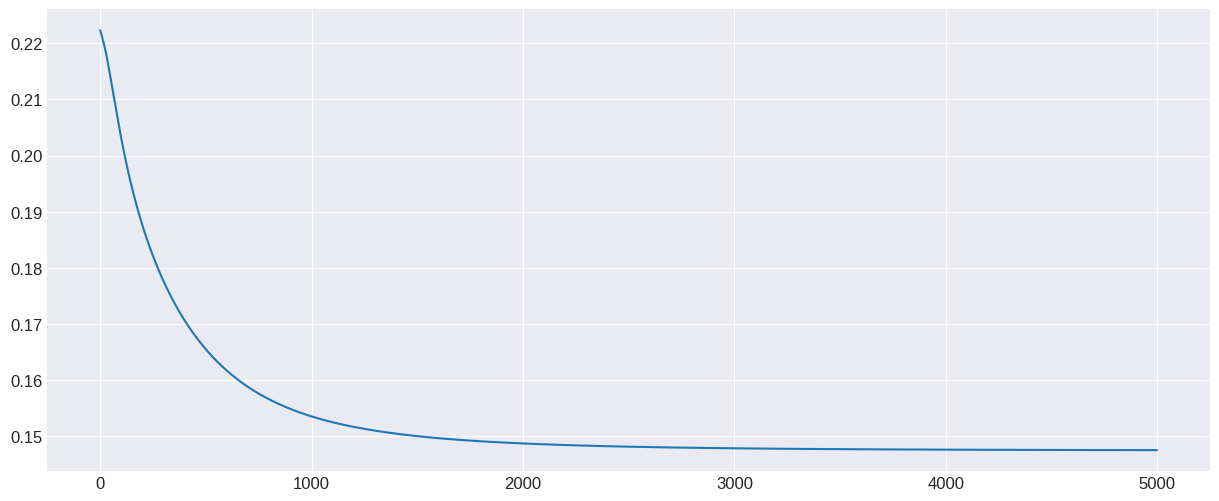

In [19]:
fig, ax = plt.subplots()
ax.plot(errors)

## Question
<div style="font-family: Arial; font-size:1.2em;">
Why do we keep training and not stop at min training error? Hold on! We would get to that eventually.
</div>

## 7. Predictions

### Train Set

In [20]:
predictions =[] # list

for row in data_train: # iterate ove all rows
    
    prediction = predict(row, weights) # make prediction

    if prediction > 0.5:
        y_pred = 1
    else:
        y_pred = 0
    
    
    predictions.append(y_pred) # collect them in a list

In [21]:
accuracy_score(data_train[:, -1], predictions) # calculate accuracy

0.8655555555555555

### Test Set

In [22]:
predictions =[] # list

for row in data_test: # iterate ove all rows
    
    prediction = predict(row, weights) # make prediction
    
    if prediction > 0.5:
        y_pred = 1
    else:
        y_pred = 0
    
    predictions.append(y_pred) # collect them in a list

In [23]:
accuracy_score(data_test[:, -1], predictions) # calculate accuracy

0.9

In [24]:
cm  = confusion_matrix(data_test[:, -1], predictions) # calculate accuracy)
cm

array([[55,  3],
       [ 7, 35]])

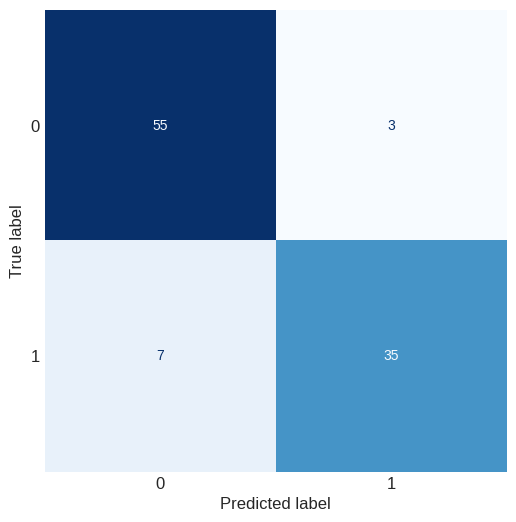

In [25]:
fig, ax = plt.subplots (figsize=(6,6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(ax = ax, cmap ='Blues', colorbar=False)

plt.grid()

In [26]:
def fn_plot_decision_boundary(X: np.ndarray):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize = (8,5));
    
    # Small increment to create object function surface
    dm = 0.05
    
    # Range of X values (First feature)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    # Range of Y values (Second feature)
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a grid to evaluate the object function
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # flatten and stack
    # arrays will be stacked along their last axis after being upgraded to at least 2-D 
    # with 1’s post-pended to the shape (column vectors made out of 1-D arrays)
    XX = np.c_[xx.ravel(), yy.ravel()] 

    # add another column filled with 1 to make it work with the predict function
    XX = np.hstack( ( XX, np.ones((XX.shape[0],1)) ) )
    
    # list to collect predictions
    y_pred = []
    
    # Iterate over rows
    for row in (XX):
        ## Changes for sigmoid
        pred = predict(row, weights)

        y_p = 0
        
        if pred >= 0.5:
            y_p = 1

        y_pred.append(y_p)
        
    Z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=X[:, 2],
                                  s=20, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

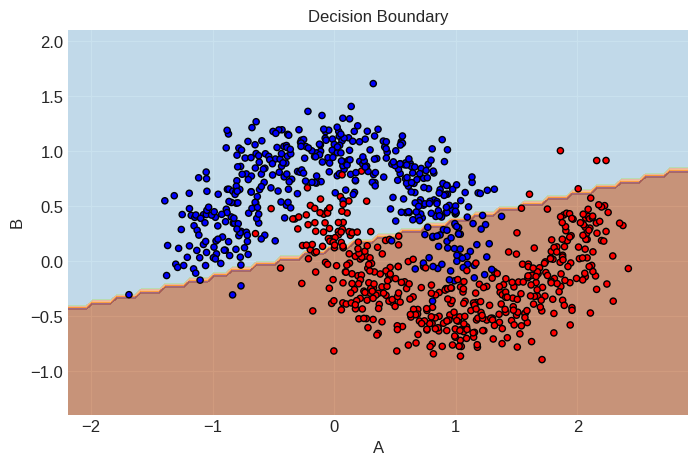

In [27]:
fn_plot_decision_boundary(data_train)

## Tracking
<div style="font-family: Arial; font-size:1.2em;color:black;">
Lets track the results across various implementations...

 |#|Implementation|Training Accuracy|Testing Accuracy|Remarks|
 |:-:|---|---|---|---|
 |1|Simple Perceptron|0.83111|0.89000||

## Notes:
<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>
<img src="../../images/dnn_nb_s03_fig2.png" width='550' align = 'right'>

## A note on Loss Function
<div style="font-family: Arial; font-size:1.2em;">
    <p>In logistic regression we are looking for if it is correct class or not. </p> 
    <p>For example, we want to know if there is a car in the picture or not. So the output is probability of a car in the picture.</p>
    <p><b>Mathematically speaking:</b></p>
    <p>$\hat{y} = p(y=1|x)$ i.e. given training sample $x$, we want to know probability of $y$ being 1.</p>
    <br>
    <p><b>Alternatively:</b></p>
    <p>If there is a car in the picture.  $\Rightarrow$  $y$ = 1 then $p(y|x)$ = $\hat{y}$.</p>
    <p>If there is <b>no</b> car in the picture.$\Rightarrow$ $y$ = 0 then $p(y|x)$ = 1 - $\hat{y}$.</p>
    <br>
    <p>We can summarize two equations as: $p(y|x)$ = $\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}$</p>
    <p>Above equation is $\hat{y}$ for y = 1 and (1 - $\hat{y}$) for y = 0.</p>
    <p>Taking log of above equation:</p>

$
\begin{aligned}
log [ p(y|x) ] & = log[\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}]\\
& = y * log(\hat{y}) + (1-y) * log(1 - \hat{y})\\
\end{aligned}
$
<p>Since we aim to minimize above function, add negative sign and our loss function becomes</p>

$
\begin{aligned}
L(\hat{y},y) =  -[y * log\hat{y} + (1-y) * log(1-\hat{y})]\\
\text{or}\\
L(a,y) =  - [ y * log ( a ) + ( 1 - y ) * log( 1 - a ) ]\\
\end{aligned}
$

|Case| y |Loss| a |-log(a)|-log(1-a)|
|:-: |:-:|:-: |:-:|  :-: |   :-:  |
| 1  | 0 | -log( 1 - a )| 0.000001 |13.8155|**1 e-6**|
| 2  | 0 | -log( 1 - a )| 0.999999 |1 e-6|**13.8155**|
| 3  | 1 | -log( a )| 0.000001 |**13.8155**|1 e-6|
| 4  | 1 | -log( a )| 0.999999 |**1 e-6**|13.8155|

</div>

<div style="font-family: Arial; font-size:1.2em;">
    <p>For binary classification the error = - $y * log(a)$</p>
    <p>We want to sum it up for all samples in the dataset. Hence:</p>

$
\begin{aligned}
p(\text{all ys | all rows of x}) & =  \Pi_{i=0}^m p(y|x)\\
log [ p(\text{all ys | all rows of x})] & =  log [ \Pi_{i=0}^m p(y|x) ]\\
& =  \sum_{i=0}^m log [ p(y|x) ] \\
& =  \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\text{Divide it by m to better scale the costs}\\
& = \frac{1}{m} * \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\end{aligned}
$

### Introducing $\mathrm{sigmoid}$ function for our binary output.
$$
\begin{aligned}
z & = x_1 . w_1 + x_2 . w_2 + b_1 \\
a & = \hat{y} = \sigma(z)\\
dz & = (a - y) \\
db & = dz\\
b & = b - \alpha . db\\
dw_1 & = x_1. dz\\
dw_2 & = x_2.dz\\
w_1 & = w_1 - \alpha . dw_1\\
w_2 & = w_1 - \alpha . dw_2\\
\end{aligned}
$$
### Sigmoid function
$$
\begin{align}
a &= \sigma(z)\\
&= \dfrac{1}{1 + e^{-z}}\\
\end{align}
$$
    <h3>Derivative of sigmoid function</h3>
$$
\begin{align}
\partial{a} &= \partial{(\sigma(z))}\\
&= \dfrac{\partial}{\partial{z}} \left[ \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{\partial}{\partial{z}} \left( 1 + \mathrm{e}^{-z} \right)^{-1} \\
&= -(1 + e^{-z})^{-2}(-e^{-z}) \\
&= \dfrac{e^{-z}}{\left(1 + e^{-z}\right)^2} \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{e^{-z}}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{(1 + e^{-z}) - 1}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ \dfrac{1 + e^{-z}}{1 + e^{-z}} - \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ 1 - \dfrac{1}{1 + e^{-z}} \right] \\
&= \sigma(z) \circ (1 - \sigma(z))\\
&= a \circ (1 - a)
\end{align}
$$
    </div>